### download dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -q install --upgrade --no-cache-dir gdown

In [ ]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 45.9 MB/s eta 0:00:00


In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 KB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 KB 13.2 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/XL2248/MSCTD

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 16.48 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Updating files: 100% (934/934), done.


In [ ]:
!pip -q install --upgrade --no-cache-dir gdown

In [ ]:
# !gdown --id 1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj
!cp /content/drive/MyDrive/deep_learning_project/train_ende.zip /content/

In [ ]:
# !gdown --id 1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W
!cp /content/drive/MyDrive/deep_learning_project/test.zip /content/

In [ ]:
# !gdown --id 12HM8uVNjFg-HRZ15ADue4oLGFAYQwvTA
!cp /content/drive/MyDrive/deep_learning_project/dev.zip /content/

In [ ]:
!mkdir /content/dataset

In [ ]:
!unzip /content/train_ende.zip -d /content/dataset
!unzip /content/test.zip -d /content/dataset
!unzip /content/dev.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/dev/1054.jpg  
  inflating: /content/dataset/dev/1055.jpg  
  inflating: /content/dataset/dev/1056.jpg  
  inflating: /content/dataset/dev/1057.jpg  
  inflating: /content/dataset/dev/1058.jpg  
  inflating: /content/dataset/dev/1059.jpg  
  inflating: /content/dataset/dev/106.jpg  
  inflating: /content/dataset/dev/1060.jpg  
  inflating: /content/dataset/dev/1061.jpg  
  inflating: /content/dataset/dev/1062.jpg  
  inflating: /content/dataset/dev/1063.jpg  
  inflating: /content/dataset/dev/1064.jpg  
  inflating: /content/dataset/dev/1065.jpg  
  inflating: /content/dataset/dev/1066.jpg  
  inflating: /content/dataset/dev/1067.jpg  
  inflating: /content/dataset/dev/1068.jpg  
  inflating: /content/dataset/dev/1069.jpg  
  inflating: /content/dataset/dev/107.jpg  
  inflating: /content/dataset/dev/1070.jpg  
  inflating: /content/dataset/dev/1071.jpg  
  inflating: /content/dataset/dev/1072.jpg  
  infl

## imports

In [ ]:
from torch.utils.data import Dataset
from torchvision.io import read_image
import os
import glob
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import cv2
import ast
import torch
from itertools import groupby
from scipy import stats
import matplotlib
from collections import Counter
from tqdm import tqdm
from facenet_pytorch import MTCNN
import torchvision.transforms as T
from PIL import Image
import contractions

## **Dataset class and Dataloader**

In [ ]:
x=[]
y=[]
path = '/content/dataset/'
dataset_folders = os.listdir(path)
for folder in dataset_folders:
  images = glob.glob(path + folder + '/*.jpg')
  for image in images:
    img = cv2.imread(image)
    x.append(img.shape[0])
    y.append(img.shape[1])
print('resize values: {} , {}'.format(min(x), min(y)))

resize values: 338 , 720


In [ ]:
class MSCTDDataset(Dataset):
    def __init__(self,type_dataset, ende_dir, dataset_path, transform=T.ToTensor(), target_transform=None):

        self.type_dataset = type_dataset
        self.english_file = open(ende_dir + '/english_' + self.type_dataset + '.txt', 'r')
        self.english_Lines = [line.strip() for line in self.english_file]


        self.image_index_file = open(ende_dir + '/image_index_' + self.type_dataset + '.txt', 'r')
        self.image_index_Lines = [ast.literal_eval(line.strip()) for line in self.image_index_file]

        self.sentiment_file = open(ende_dir + '/sentiment_' + self.type_dataset + '.txt', 'r')
        self.sentiment_Lines = [int(line.strip()) for line in self.sentiment_file]

        self.id = [i for i in range(len(self.english_Lines))]

        self.dataset_path = dataset_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.english_Lines)

    def __getitem__(self, idx):

        id = self.id[idx]
        text = self.english_Lines[idx]

        if self.type_dataset == 'train':
          img_path = os.path.join(self.dataset_path, 'train_ende/' + str(idx) + '.jpg')
        else:
          img_path = os.path.join(self.dataset_path, self.type_dataset + '/' + str(idx) + '.jpg')

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_array = cv2.resize(img, (720,338), interpolation = cv2.INTER_AREA)


        sentiment = self.sentiment_Lines[idx]


        value_in_sublist = map(lambda x: id in x, self.image_index_Lines)
        my_idx = list(value_in_sublist).index(True)
        conversation_id = str(self.image_index_Lines[my_idx])


        if self.transform:
            img_array = self.transform(img_array)
        if self.target_transform:
            label = self.target_transform(label)

        sample_dict = {'id':id, 'text': text , 'image':img_array ,'sentiment':sentiment, 'conversation_id':conversation_id}

        return sample_dict

In [ ]:
train_data = MSCTDDataset('train', '/content/MSCTD/MSCTD_data/ende', '/content/dataset')
dev_data = MSCTDDataset('dev', '/content/MSCTD/MSCTD_data/ende', '/content/dataset')
test_data = MSCTDDataset('test', '/content/MSCTD/MSCTD_data/ende', '/content/dataset')

### Dataloader

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False)
dev_dataloader = DataLoader(dev_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

#**Data analysis**

##1,2,3

###train results

In [ ]:
ids=[]
text=[]
sentiments =[]
conversation_ids=[]
for batch, sample in enumerate(train_dataloader):
  text.extend(sample['text'])
  ids.extend(sample['id'])
  sentiments.extend(sample['sentiment'])
  conversation_ids.extend(sample['conversation_id'])

#dict = {i:None for i in conversation_ids}
#conversation_ids = list(dict.keys())


####1

In [ ]:
tensor=torch.tensor(sentiments)
sentiments=tensor.numpy()

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


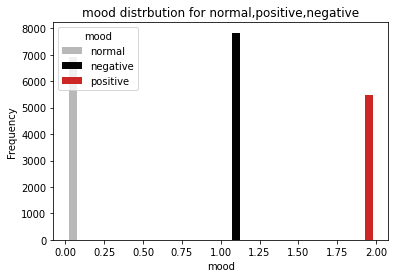

In [ ]:
plt.hist([sentiments[sentiments == 0], sentiments[sentiments == 1],sentiments[sentiments == 2]],color = ['#B8B8B8', '#030303','#CD2626'], label=['normal', 'negetive','positive'])
plt.legend()
plt.xlabel('mood')
plt.ylabel('Frequency')
plt.title('mood distrbution for normal,positive,negative')
import seaborn as sns
plt.legend(title='mood', loc='upper left', labels=[ 'normal','negative','positive'])
plt.show()

####2

In [ ]:
num_words = [len(sentence.split()) for sentence in text]

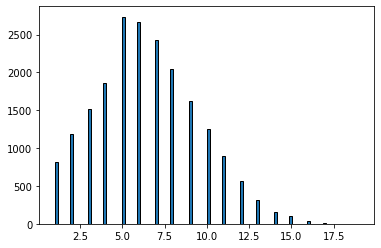

mean= 6.4644268774703555
variance= 9.247252339514754


In [ ]:
m=max(num_words)
n=min(num_words)




np.random.seed(1)
data = num_words
plt.hist(data, bins=100, range=(n,m), edgecolor='black')
plt.show()
mean = np.mean(data)
print('mean=',mean)
variance=np.var(data)
print('variance=',variance)

####3

In [ ]:
dict = {i:None for i in conversation_ids}
conversation_ids = list(dict.keys())

In [ ]:
list_num=[]
for i in conversation_ids:
  z=np.array(ast.literal_eval(i))
  y = np.asarray(z,dtype=float)
  list_num.append(len(y))



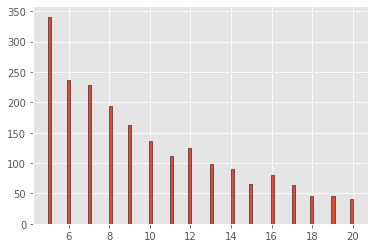

mean= 9.796708615682478
variance= 17.69632992187156


In [ ]:
m=max(list_num)
n=min(list_num)
import numpy as np
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

np.random.seed(1)
plt.hist(list_num,bins=100,range=(n,m), edgecolor='black')
plt.show()
mean = np.mean(list_num)
print('mean=',mean)
variance=np.var(list_num)
print('variance=',variance)

###validation results

In [ ]:
ids=[]
text=[]
sentiments =[]
conversation_ids=[]
for batch, sample in enumerate(dev_dataloader):
  text.extend(sample['text'])
  ids.extend(sample['id'])
  sentiments.extend(sample['sentiment'])
  conversation_ids.extend(sample['conversation_id'])

dict = {i:None for i in conversation_ids}
conversation_ids = list(dict.keys())

####1

In [ ]:
tensor=torch.tensor(sentiments)
sentiments=tensor.numpy()


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


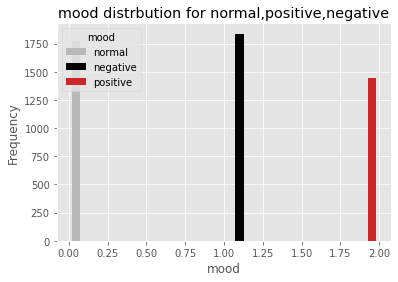

In [ ]:
plt.hist([sentiments[sentiments == 0], sentiments[sentiments == 1],sentiments[sentiments == 2]],color = ['#B8B8B8', '#030303','#CD2626'], label=['normal', 'negetive','positive'])
plt.legend()
plt.xlabel('mood')
plt.ylabel('Frequency')
plt.title('mood distrbution for normal,positive,negative')
import seaborn as sns
plt.legend(title='mood', loc='upper left', labels=[ 'normal','negative','positive'])
plt.show()

####2

In [ ]:
num_words = [len(sentence.split()) for sentence in text]

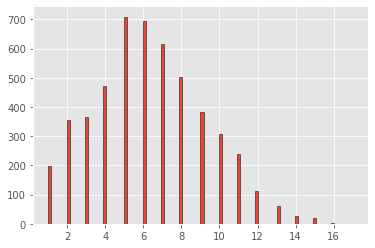

mean= 6.310290341694648
variance= 8.630759208611043


In [ ]:
m=max(num_words)
n=min(num_words)




np.random.seed(1)
data = num_words
plt.hist(data, bins=100, range=(n,m), edgecolor='black')
plt.show()
mean = np.mean(data)
print('mean=',mean)
variance=np.var(data)
print('variance=',variance)

####3

In [ ]:
list_num=[]
for i in conversation_ids:
  z=np.array(ast.literal_eval(i))
  y = np.asarray(z,dtype=float)
  list_num.append(len(y))

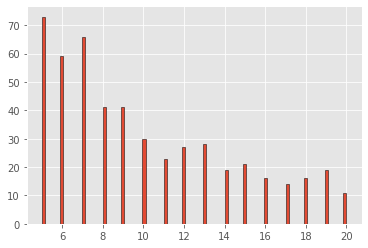

mean= 10.045634920634921
variance= 19.253869834971024


In [ ]:
m=max(list_num)
n=min(list_num)
import numpy as np
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

np.random.seed(1)
plt.hist(list_num,bins=100,range=(n,m), edgecolor='black')
plt.show()
mean = np.mean(list_num)
print('mean=',mean)
variance=np.var(list_num)
print('variance=',variance)

###test result

In [ ]:
ids=[]
text=[]
sentiments =[]
conversation_ids=[]
for batch, sample in enumerate(test_dataloader):
  text.extend(sample['text'])
  ids.extend(sample['id'])
  sentiments.extend(sample['sentiment'])
  conversation_ids.extend(sample['conversation_id'])

dict = {i:None for i in conversation_ids}
conversation_ids = list(dict.keys())

####1

In [ ]:
tensor=torch.tensor(sentiments)
sentiments=tensor.numpy()

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


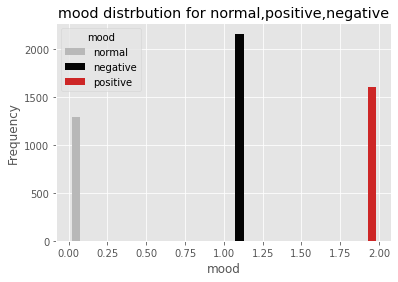

In [ ]:
plt.hist([sentiments[sentiments == 0], sentiments[sentiments == 1],sentiments[sentiments == 2]],color = ['#B8B8B8', '#030303','#CD2626'], label=['normal', 'negetive','positive'])
plt.legend()
plt.xlabel('mood')
plt.ylabel('Frequency')
plt.title('mood distrbution for normal,positive,negative')
import seaborn as sns
plt.legend(title='mood', loc='upper left', labels=[ 'normal','negative','positive'])
plt.show()

####2

In [ ]:
num_words = [len(sentence.split()) for sentence in text]

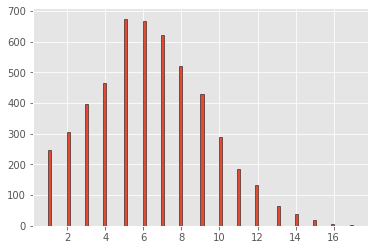

mean= 6.303927373199132
variance= 8.892826494034605


In [ ]:
m=max(num_words)
n=min(num_words)




np.random.seed(1)
data = num_words
plt.hist(data, bins=100, range=(n,m), edgecolor='black')
plt.show()
mean = np.mean(data)
print('mean=',mean)
variance=np.var(data)
print('variance=',variance)

####3

In [ ]:
list_num=[]
for i in conversation_ids:
  z=np.array(ast.literal_eval(i))
  y = np.asarray(z,dtype=float)
  list_num.append(len(y))

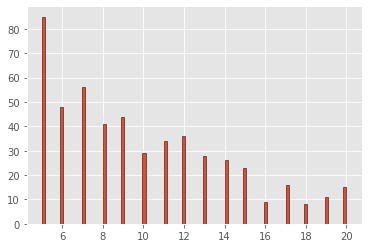

mean= 9.954813359528487
variance= 17.752378599742936


In [ ]:
m=max(list_num)
n=min(list_num)
import numpy as np
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

np.random.seed(1)
plt.hist(list_num,bins=100,range=(n,m), edgecolor='black')
plt.show()
mean = np.mean(list_num)
print('mean=',mean)
variance=np.var(list_num)
print('variance=',variance)

In [ ]:
ids
main_ids = ids
temp_list = []
for i in main_ids:
    if i not in temp_list:
        temp_list.append(i)
main_ids = temp_list

##4

### Train

In [ ]:
transform = T.ToPILImage()
mtcnn = MTCNN(keep_all=True, post_process=False, device='cuda:0') #keep all faces, load model on cuda, don't normalize faces after
face_count = []
for batch, sample in enumerate(tqdm(train_dataloader)):
  imgs_PIL = []
  faces = []
  for i in range(len(sample['image'])):
    imgs_PIL.append(transform(sample['image'][i])) #mtcnn only accepts batches of PIL image

  faces = mtcnn(imgs_PIL) #returns positions of bbox, eyes, lips ,...
  for i in range(len(faces)) :
    if faces[i] is None : # no face detected
      face_count.append(0)
    else:
      face_count.append(len(faces[i]))





  0%|          | 0/317 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a

In [ ]:
max(face_count)

58

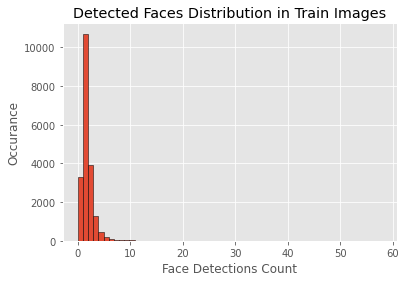

In [ ]:
plt.hist(face_count, bins=max(face_count)+1, edgecolor='black')
plt.xlabel('Face Detections Count')
plt.ylabel('Occurance')
plt.title('Detected Faces Distribution in Train Images')
plt.show()

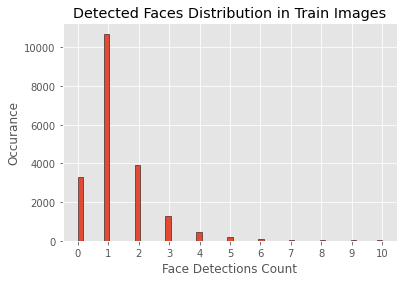

In [ ]:
plt.hist(face_count, bins=max(face_count)+1, range = (0,10), edgecolor='black')
plt.xticks(range(11))
plt.xlabel('Face Detections Count')
plt.ylabel('Occurance')
plt.title('Detected Faces Distribution in Train Images')
plt.show()

### Validation

In [ ]:
face_count_dev = []
for batch, sample in enumerate(tqdm(dev_dataloader)):
  imgs_PIL = []
  faces = []
  for i in range(len(sample['image'])):
    imgs_PIL.append(transform(sample['image'][i]))

  faces = mtcnn(imgs_PIL)
  for i in range(len(faces)) :
    if faces[i] is None :
      face_count_dev.append(0)
    else:
      face_count_dev.append(len(faces[i]))

100%|██████████| 80/80 [03:29<00:00,  2.62s/it]


In [ ]:
max(face_count_dev)

60

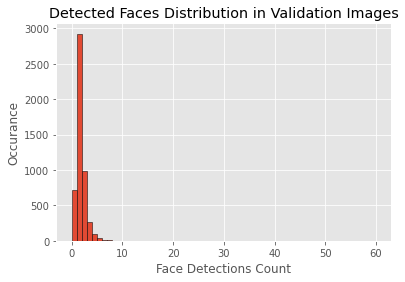

In [ ]:
plt.hist(face_count_dev, bins=max(face_count_dev)+1, edgecolor='black')
plt.xlabel('Face Detections Count')
plt.ylabel('Occurance')
plt.title('Detected Faces Distribution in Validation Images')
plt.show()

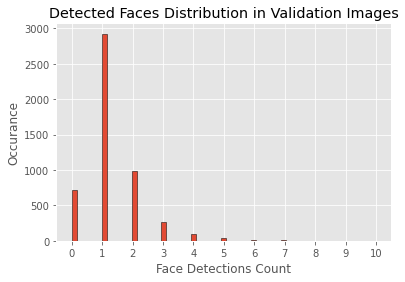

In [ ]:
plt.hist(face_count_dev, bins=max(face_count_dev)+1, range = (0,10), edgecolor='black')
plt.xticks(range(11))
plt.xlabel('Face Detections Count')
plt.ylabel('Occurance')
plt.title('Detected Faces Distribution in Validation Images')
plt.show()

### Test

In [ ]:
face_count_test = []
for batch, sample in enumerate(tqdm(test_dataloader)):
  imgs_PIL = []
  faces = []
  for i in range(len(sample['image'])):
    imgs_PIL.append(transform(sample['image'][i]))

  faces = mtcnn(imgs_PIL)
  for i in range(len(faces)) :
    if faces[i] is None :
      face_count_test.append(0)
    else:
      face_count_test.append(len(faces[i]))

100%|██████████| 80/80 [03:34<00:00,  2.68s/it]


In [ ]:
max(face_count_test)

21

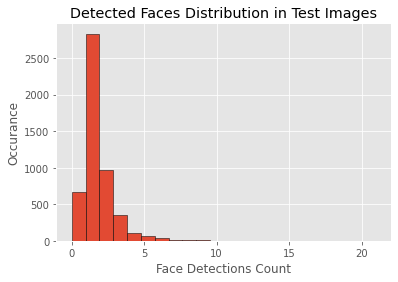

In [ ]:
plt.hist(face_count_test,bins=max(face_count_test)+1, edgecolor='black')
plt.xlabel('Face Detections Count')
plt.ylabel('Occurance')
plt.title('Detected Faces Distribution in Test Images')
plt.show()

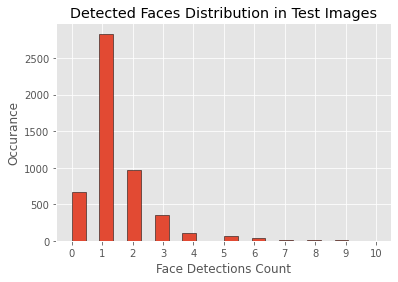

In [ ]:
plt.hist(face_count_test, bins=max(face_count_test)+1, range = (0,10), edgecolor='black')
plt.xticks(range(11))
plt.xlabel('Face Detections Count')
plt.ylabel('Occurance')
plt.title('Detected Faces Distribution in Test Images')
plt.show()

### Train-Validation-Test

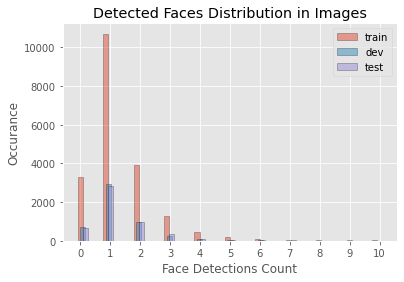

In [ ]:
plt.hist(face_count, bins=max(face_count)+1, range = (0,10), edgecolor='black', label='train', alpha=0.5, align='left')
plt.hist(face_count_dev, bins=max(face_count)+1, range = (0,10), edgecolor='black', label='dev', alpha = 0.5, align='mid')
plt.hist(face_count_test, bins=max(face_count)+1, range = (0,10), edgecolor='black', label='test', alpha =0.5,align='right')
plt.xticks(range(11))
plt.legend(loc='upper right')
plt.xlabel('Face Detections Count')
plt.ylabel('Occurance')
plt.title('Detected Faces Distribution in Images')
plt.show()

##5

### Train

In [ ]:

text_train=[]
sentiments_train =[]

for batch, sample in enumerate(tqdm(train_dataloader)):
  text_train.extend(sample['text'])
  sentiments_train.extend(sample['sentiment'])

100%|██████████| 317/317 [06:28<00:00,  1.23s/it]


In [ ]:
word_count_train = [len(contractions.fix(sentence).split()) for sentence in text_train]

In [ ]:
word_count_train= np.asarray(word_count_train)
sentiments_train = np.asarray(sentiments_train)

In [ ]:
idx0_train = np.where(sentiments_train == 0)[0]
word0_count_train = word_count_train[idx0_train]
mean_word0_count_train = word0_count_train.mean()
len(idx0_train) , word0_count_train.sum() , mean_word0_count_train

(6922, 42741, 6.174660502744872)

In [ ]:
idx1_train = np.where(sentiments_train == 1)[0]
word1_count_train = word_count_train[idx1_train]
mean_word1_count_train = word1_count_train.mean()
len(idx1_train) , word1_count_train.sum() , mean_word1_count_train

(7835, 56644, 7.229610721123166)

In [ ]:
idx2_train = np.where(sentiments_train == 2)[0]
word2_count_train = word_count_train[idx2_train]
mean_word2_count_train = word2_count_train.mean()
len(idx2_train) , word2_count_train.sum() , mean_word2_count_train

(5483, 39025, 7.117453948568302)

### Validation

In [ ]:
text_dev=[]
sentiments_dev =[]

for batch, sample in enumerate(tqdm(dev_dataloader)):
  text_dev.extend(sample['text'])
  sentiments_dev.extend(sample['sentiment'])

100%|██████████| 80/80 [01:27<00:00,  1.09s/it]


In [ ]:
word_count_dev = [len(contractions.fix(sentence).split()) for sentence in text_dev]

In [ ]:
word_count_dev= np.asarray(word_count_dev)
sentiments_dev = np.asarray(sentiments_dev)

In [ ]:
idx0_dev = np.where(sentiments_dev == 0)[0]
word0_count_dev = word_count_dev[idx0_dev]
mean_word0_count_dev = word0_count_dev.mean()
len(idx0_dev) , word0_count_dev.sum() , mean_word0_count_dev

(1777, 11090, 6.240855374226224)

In [ ]:
idx1_dev = np.where(sentiments_dev == 1)[0]
word1_count_dev = word_count_dev[idx1_dev]
mean_word1_count_dev = word1_count_dev.mean()
len(idx1_dev) , word1_count_dev.sum() , mean_word1_count_dev

(1838, 13067, 7.109357997823722)

In [ ]:
idx2_dev = np.where(sentiments_dev == 2)[0]
word2_count_dev = word_count_dev[idx2_dev]
mean_word2_count_dev = word2_count_dev.mean()
len(idx2_dev) , word2_count_dev.sum() , mean_word2_count_dev

(1448, 9657, 6.669198895027624)

### Test

In [ ]:
text_test=[]
sentiments_test =[]

for batch, sample in enumerate(tqdm(test_dataloader)):
  text_test.extend(sample['text'])
  sentiments_test.extend(sample['sentiment'])

100%|██████████| 80/80 [01:28<00:00,  1.10s/it]


In [ ]:
word_count_test = [len(contractions.fix(sentence).split()) for sentence in text_test]

In [ ]:
word_count_test= np.asarray(word_count_test)
sentiments_test = np.asarray(sentiments_test)

In [ ]:
idx0_test = np.where(sentiments_test == 0)[0]
word0_count_test = word_count_test[idx0_test]
mean_word0_count_test = word0_count_test.mean()
len(idx0_test) , word0_count_test.sum() , mean_word0_count_test

(1298, 7834, 6.035439137134053)

In [ ]:
idx1_test = np.where(sentiments_test == 1)[0]
word1_count_test = word_count_test[idx1_test]
mean_word1_count_test = word1_count_test.mean()
len(idx1_test) , word1_count_test.sum() , mean_word1_count_test

(2163, 15102, 6.981969486823855)

In [ ]:
idx2_test = np.where(sentiments_test == 2)[0]
word2_count_test = word_count_test[idx2_test]
mean_word2_count_test = word2_count_test.mean()
len(idx2_test) , word2_count_test.sum() , mean_word2_count_test

(1606, 10862, 6.763387297633873)

### plot

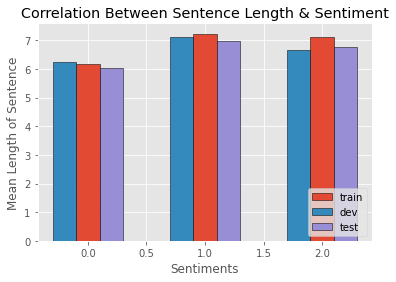

In [ ]:
labels = [0,1,2]
plt.bar([0,1,2],[mean_word0_count_train, mean_word1_count_train,mean_word2_count_train],label='train',width=0.2,edgecolor='black')
plt.bar([-0.2,0.8,1.8],[mean_word0_count_dev, mean_word1_count_dev,mean_word2_count_dev],label='dev', width=0.2,edgecolor='black')
plt.bar([0.2,1.2,2.2],[mean_word0_count_test, mean_word1_count_test,mean_word2_count_test],label='test', width=0.2,edgecolor='black')
plt.legend(loc='lower right')
plt.xlabel('Sentiments')
plt.ylabel('Mean Length of Sentence')
plt.title('Correlation Between Sentence Length & Sentiment')
plt.show()

##6

In [ ]:
def get_pattern_series(loader):

  ids=[]
  sentiments =[]
  conversation_ids=[]
  for batch, sample in enumerate(loader):
    ids.extend(sample['id'])
    sentiments.extend(sample['sentiment'])
    conversation_ids.extend(sample['conversation_id'])

  dict = {i:None for i in conversation_ids}
  conversation_ids = list(dict.keys())

  pattern_series=[]
  append = pattern_series.append
  for k in tqdm(range(len(conversation_ids))):
    conversation_id_new = ast.literal_eval(conversation_ids[k])
    l=[]
    for i in conversation_id_new:
      l.append((sentiments[ids.index(torch.tensor(i))]).item())  #find sentiment base id

    final_l = [key for key, _group in groupby(l)]

    append(str(final_l))
  return pattern_series

In [ ]:
def plot_histogram_patterns(p_keys, p_values, title):
  fig = plt.figure(figsize=(70,20))
  colors = ['green', 'blue', 'lime']
  plt.bar(p_keys, p_values, width = 1, color =colors)
  plt.title(title , fontsize=40)
  plt.xticks(range(len(p_keys)), p_keys, rotation='vertical' , fontsize=20)
  plt.yticks(fontsize=40)
  plt.show()

### train_results

In [ ]:
train_patterns = get_pattern_series(train_dataloader)

100%|██████████| 2066/2066 [08:27<00:00,  4.07it/s]


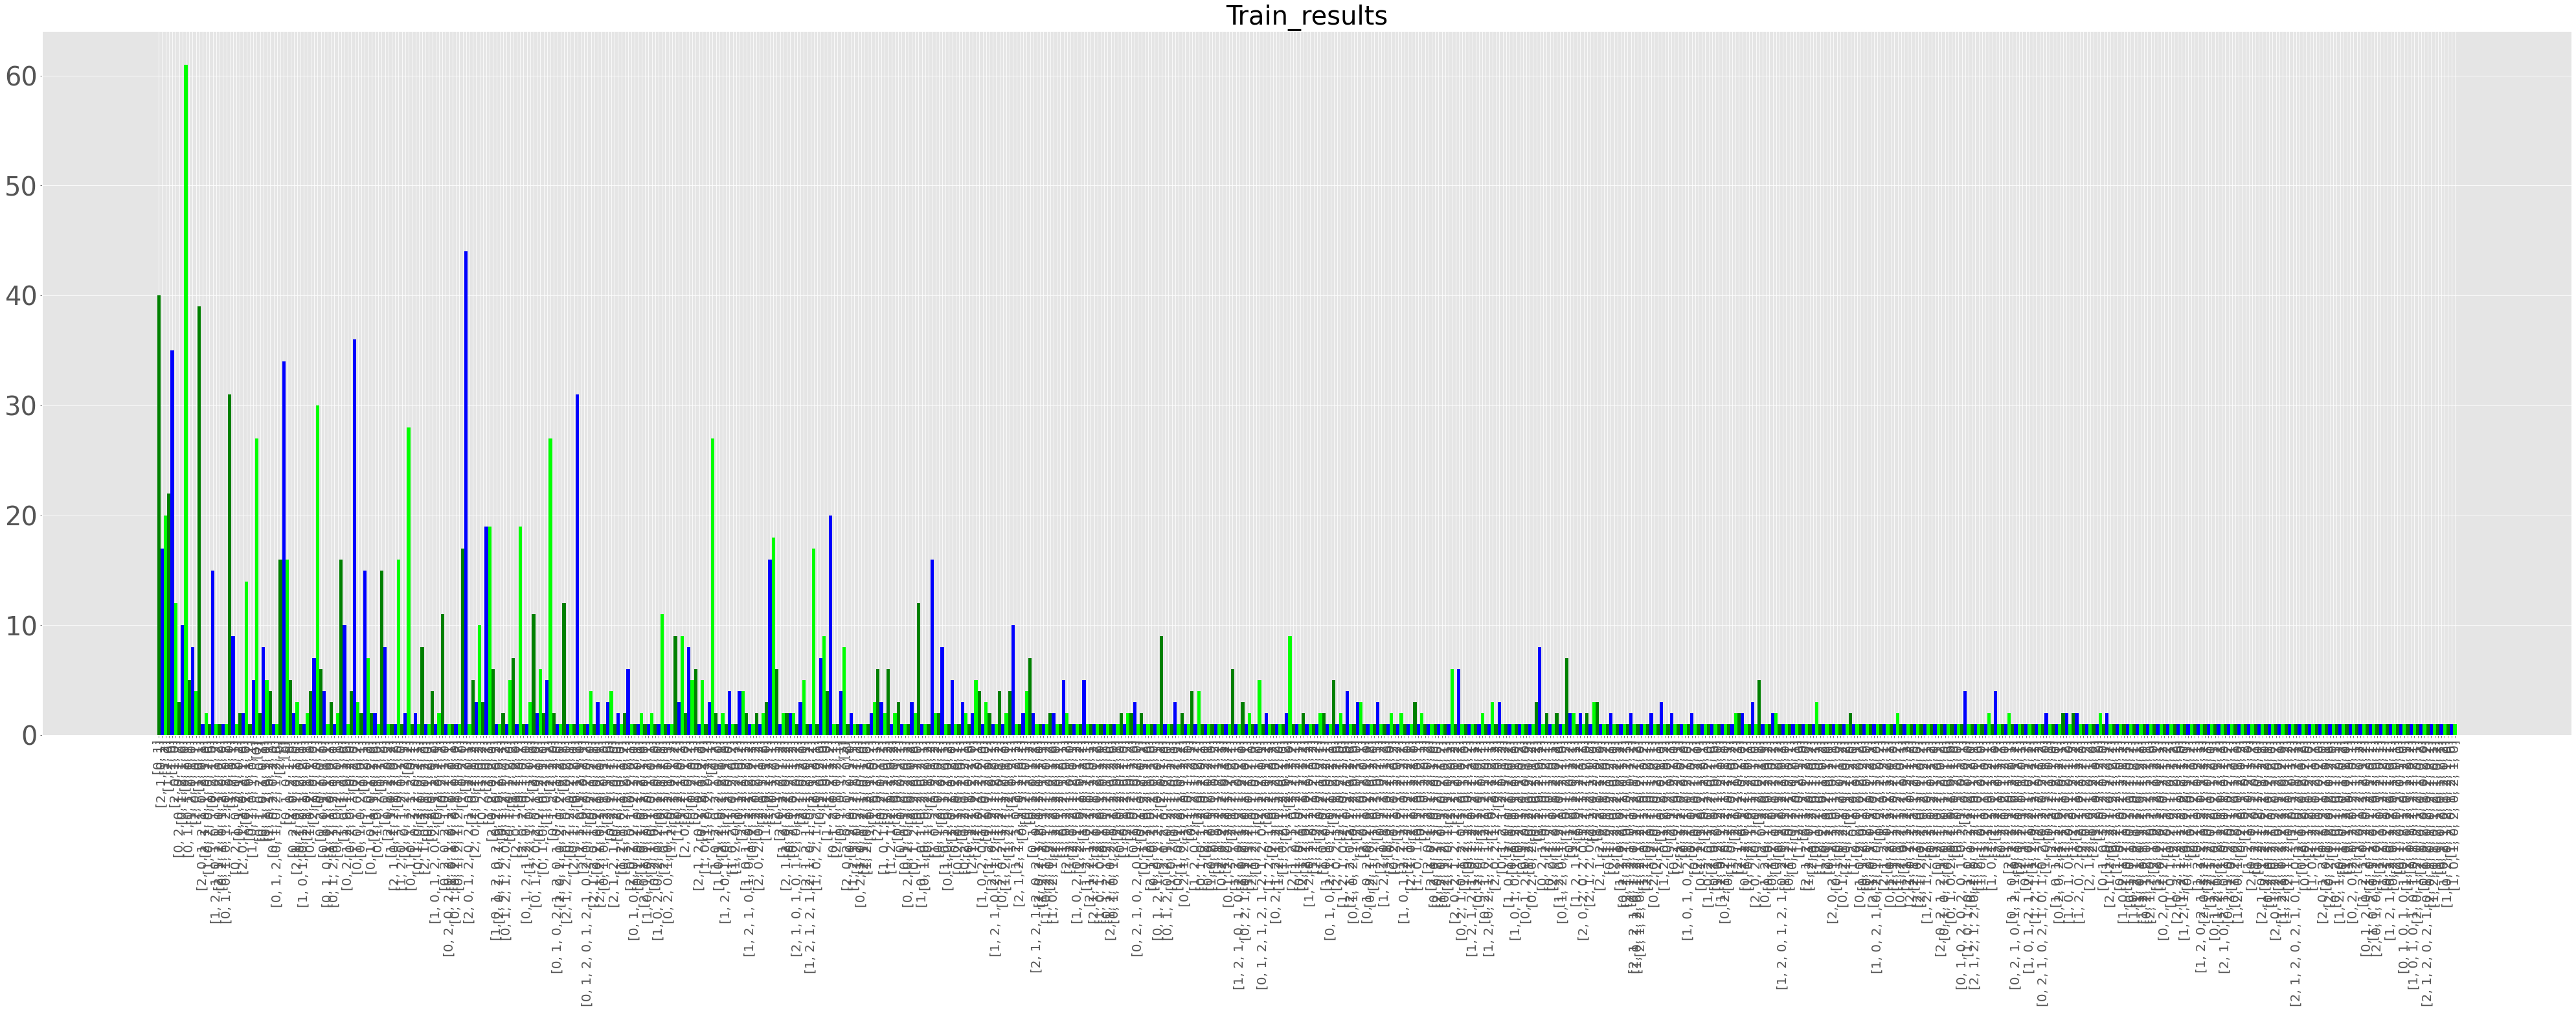

In [ ]:
p = train_patterns.copy()

p_keys = list(Counter(p).keys())
p_values = list(Counter(p).values())
plot_histogram_patterns(p_keys, p_values, 'Train_results')

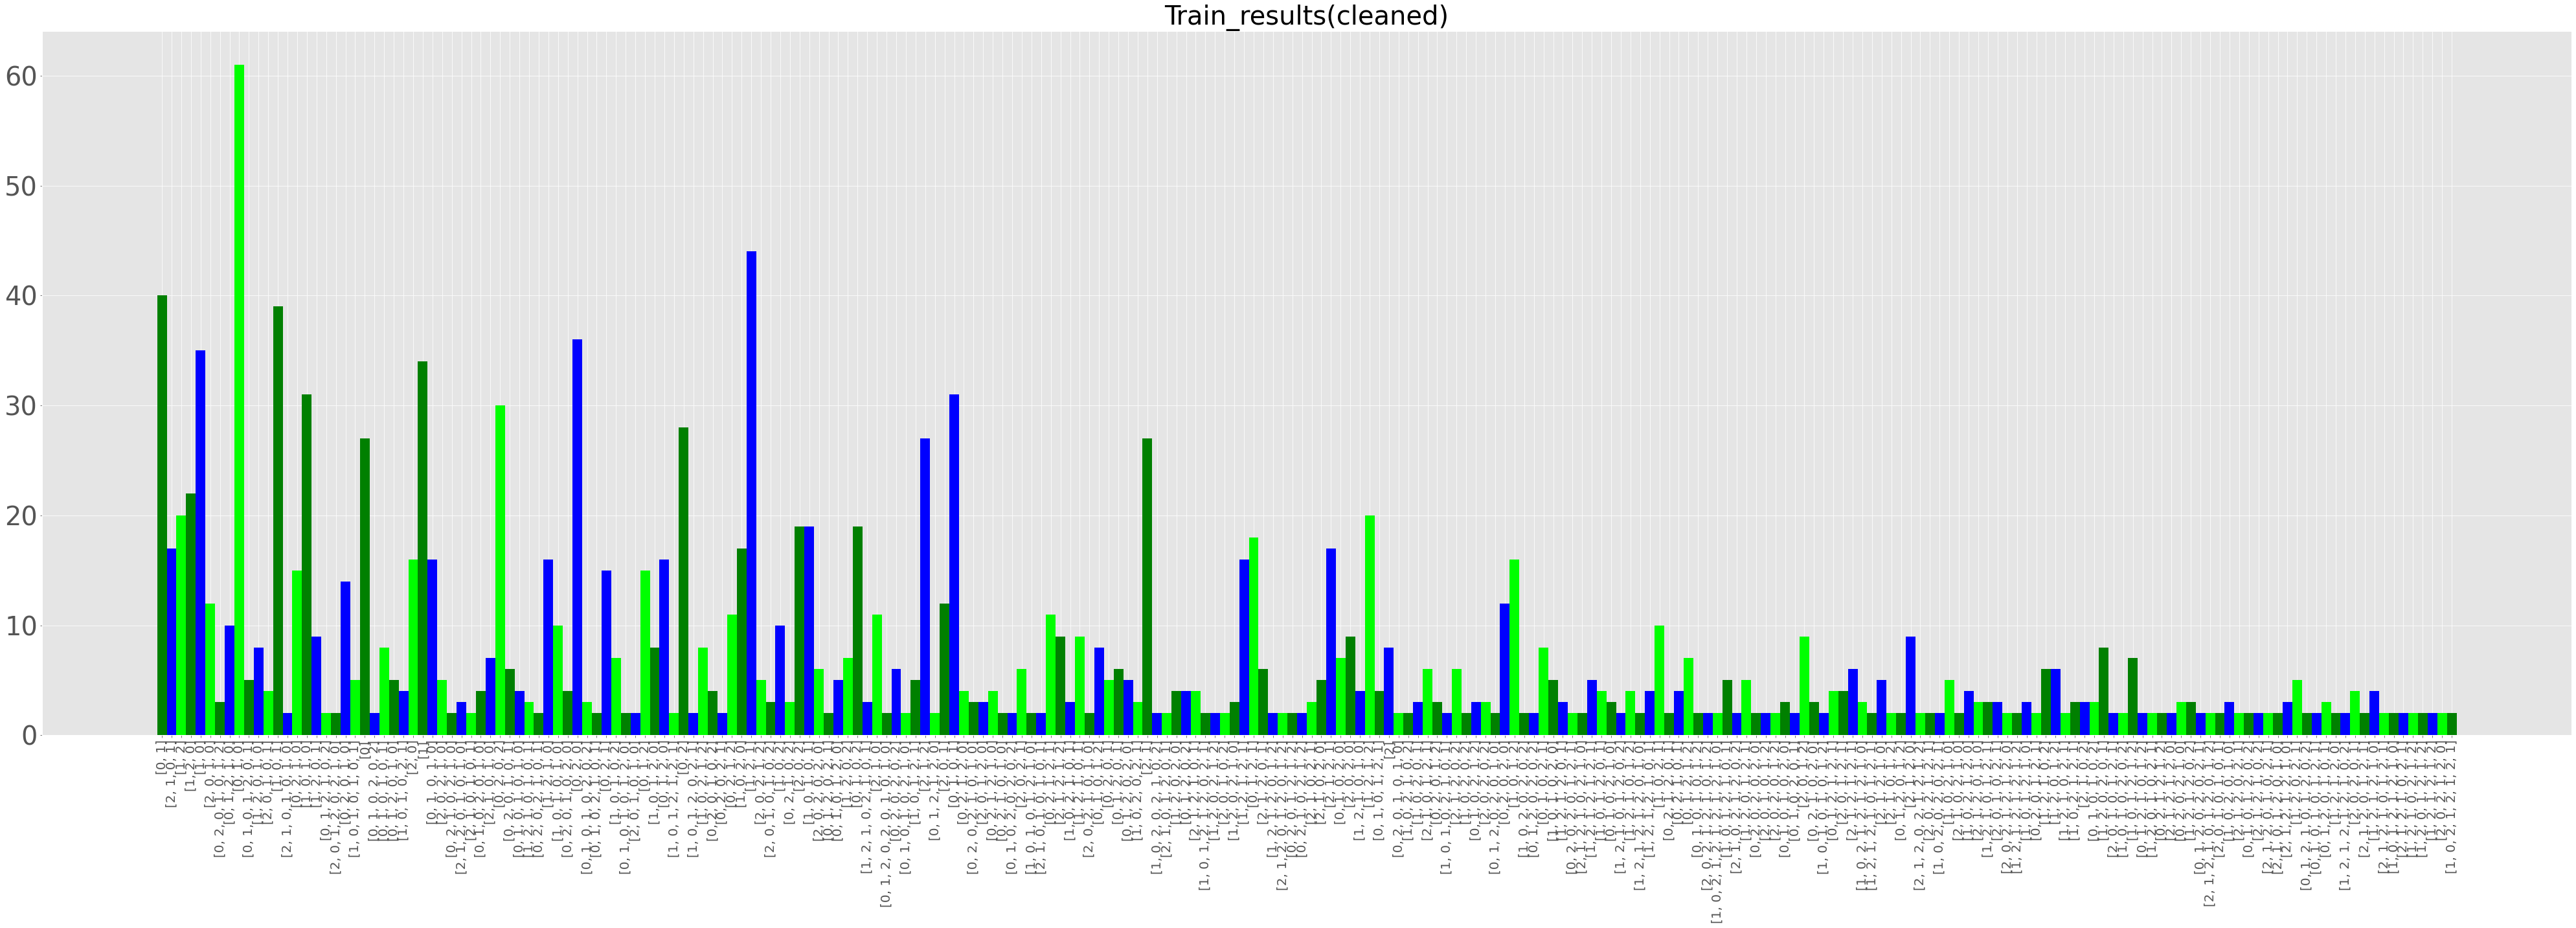

In [ ]:
#delete patter_series with one value
one_repeated_el=[]
for i in range(len(p_keys)):
  if p_values[i] == 1:
    p.remove(p_keys[i])

p_keys = list(Counter(p).keys())
p_values = list(Counter(p).values())
plot_histogram_patterns(p_keys, p_values, 'Train_results(cleaned)')

### validation_results

In [ ]:
dev_patterns = get_pattern_series(dev_dataloader)

100%|██████████| 504/504 [00:31<00:00, 15.76it/s]


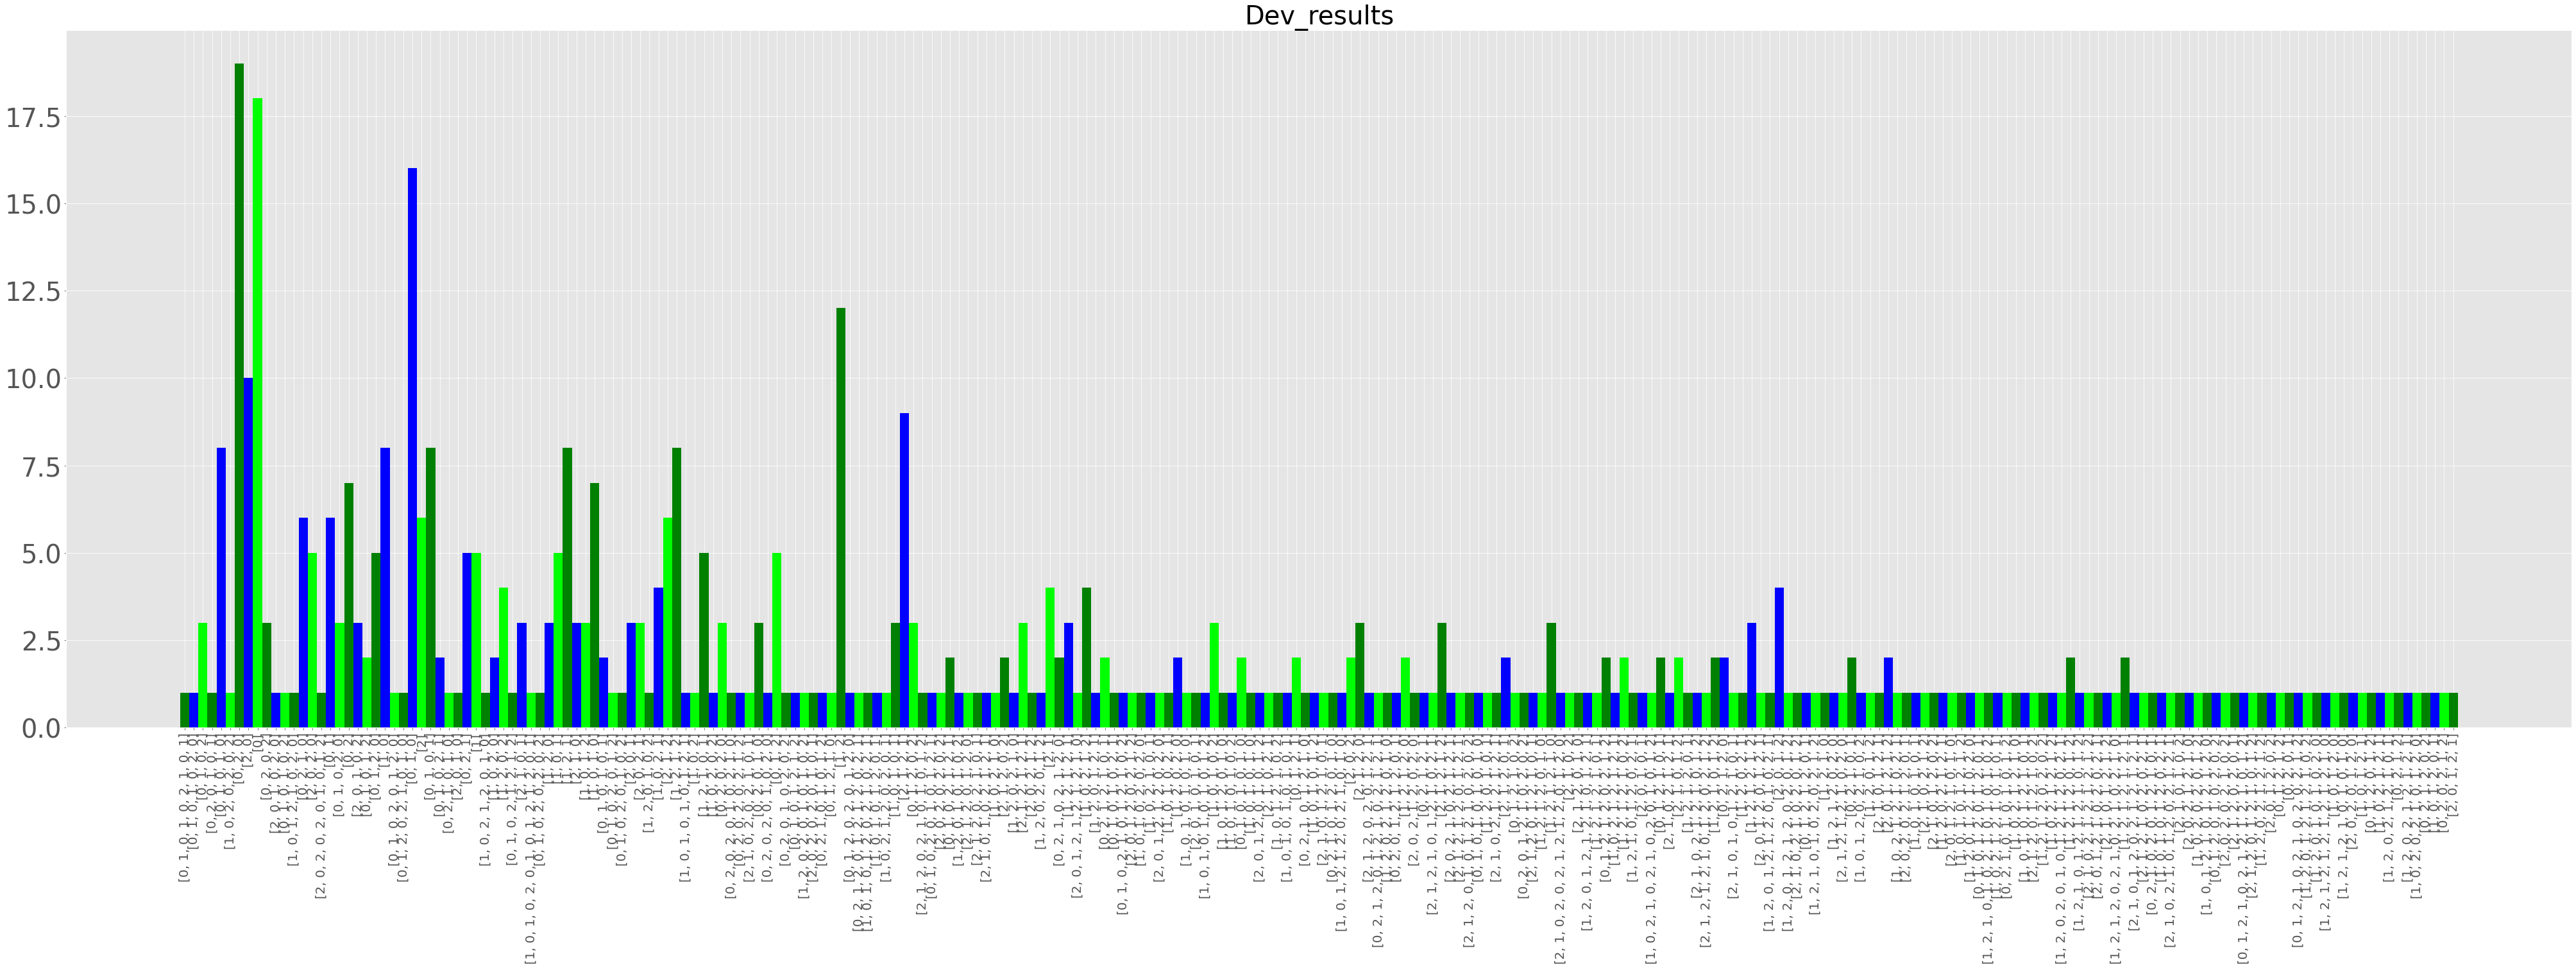

In [ ]:
p = dev_patterns.copy()

p_keys = list(Counter(p).keys())
p_values = list(Counter(p).values())
plot_histogram_patterns(p_keys, p_values, 'Dev_results')

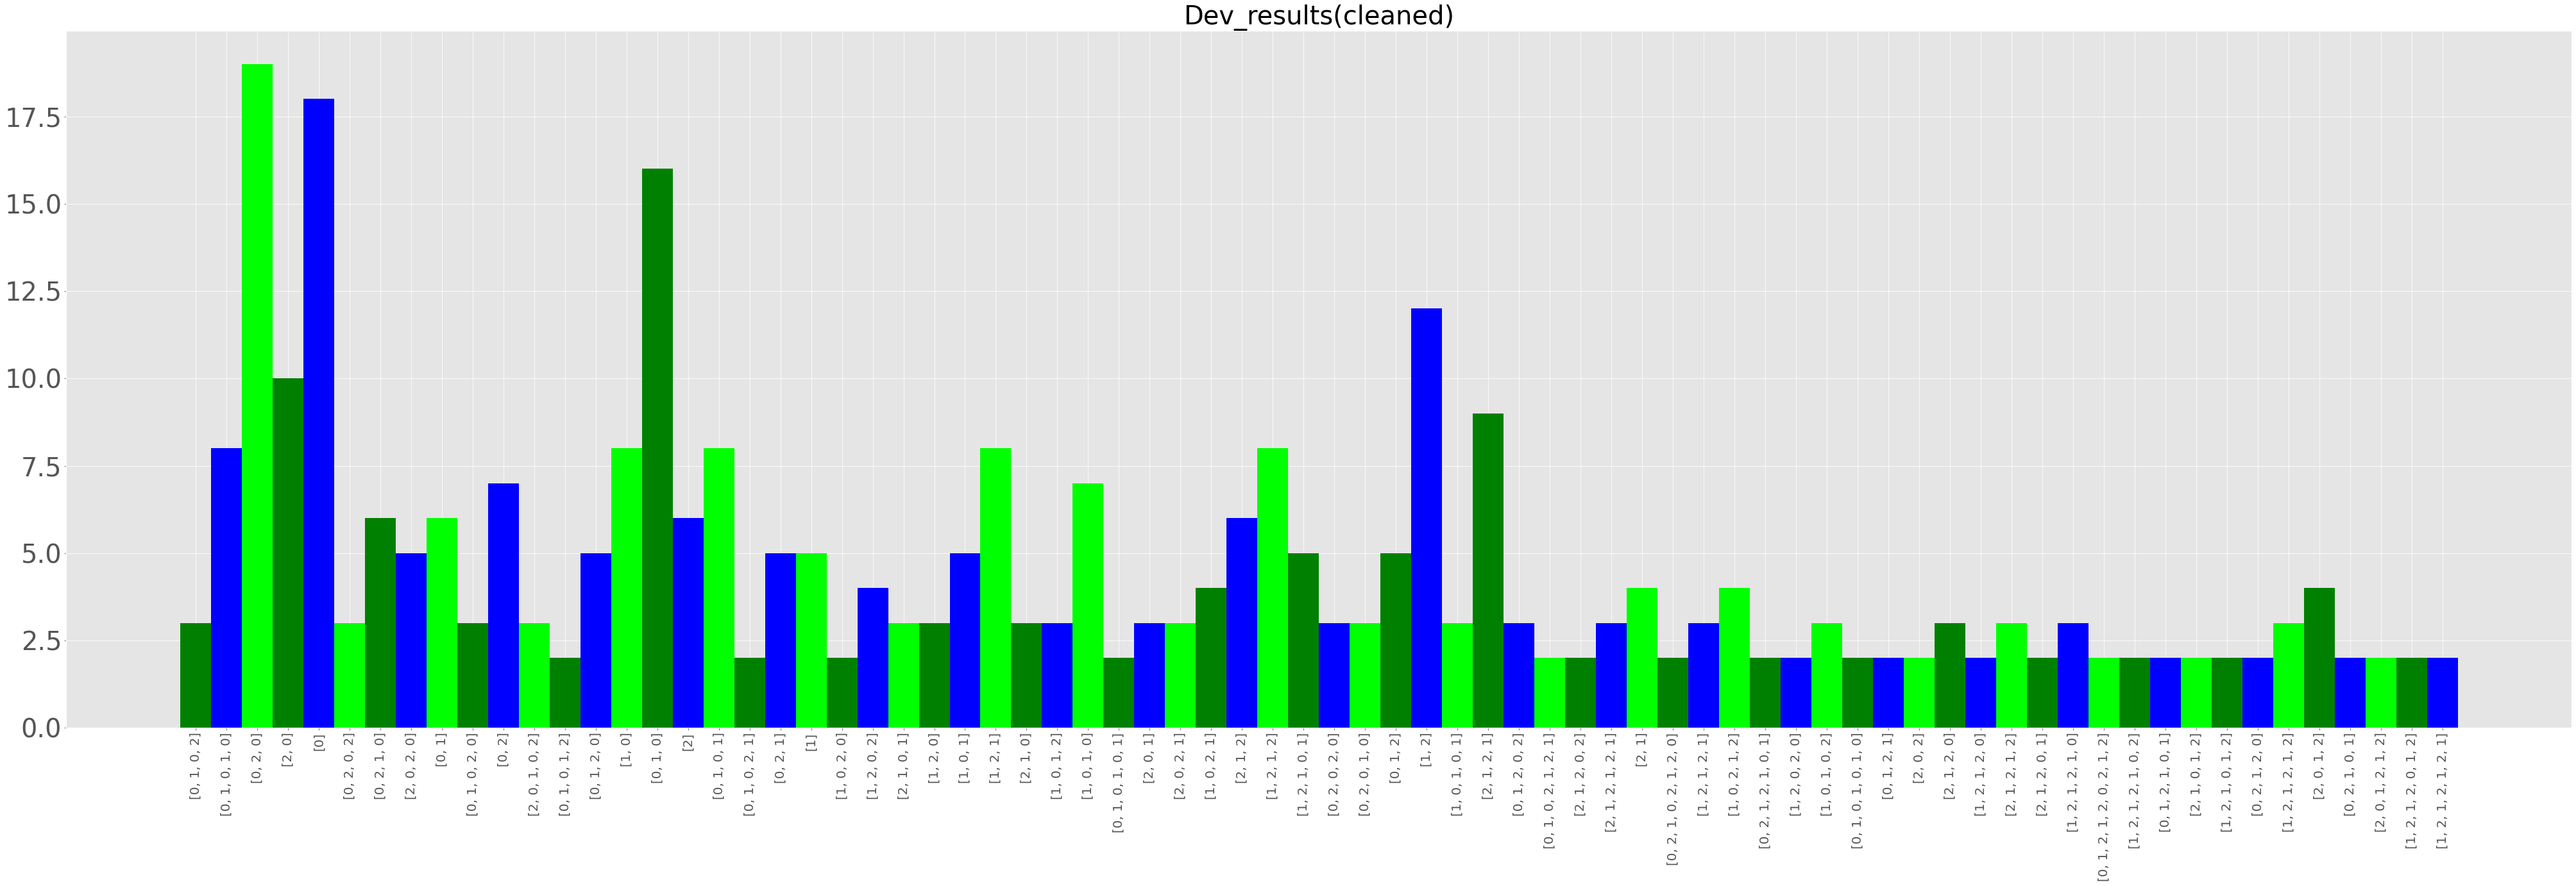

In [ ]:
#delete patter_series with one value
one_repeated_el=[]
for i in range(len(p_keys)):
  if p_values[i] == 1:
    p.remove(p_keys[i])

p_keys = list(Counter(p).keys())
p_values = list(Counter(p).values())
plot_histogram_patterns(p_keys, p_values, 'Dev_results(cleaned)')

### test_results

In [ ]:
test_patterns = get_pattern_series(test_dataloader)

100%|██████████| 509/509 [00:32<00:00, 15.57it/s]


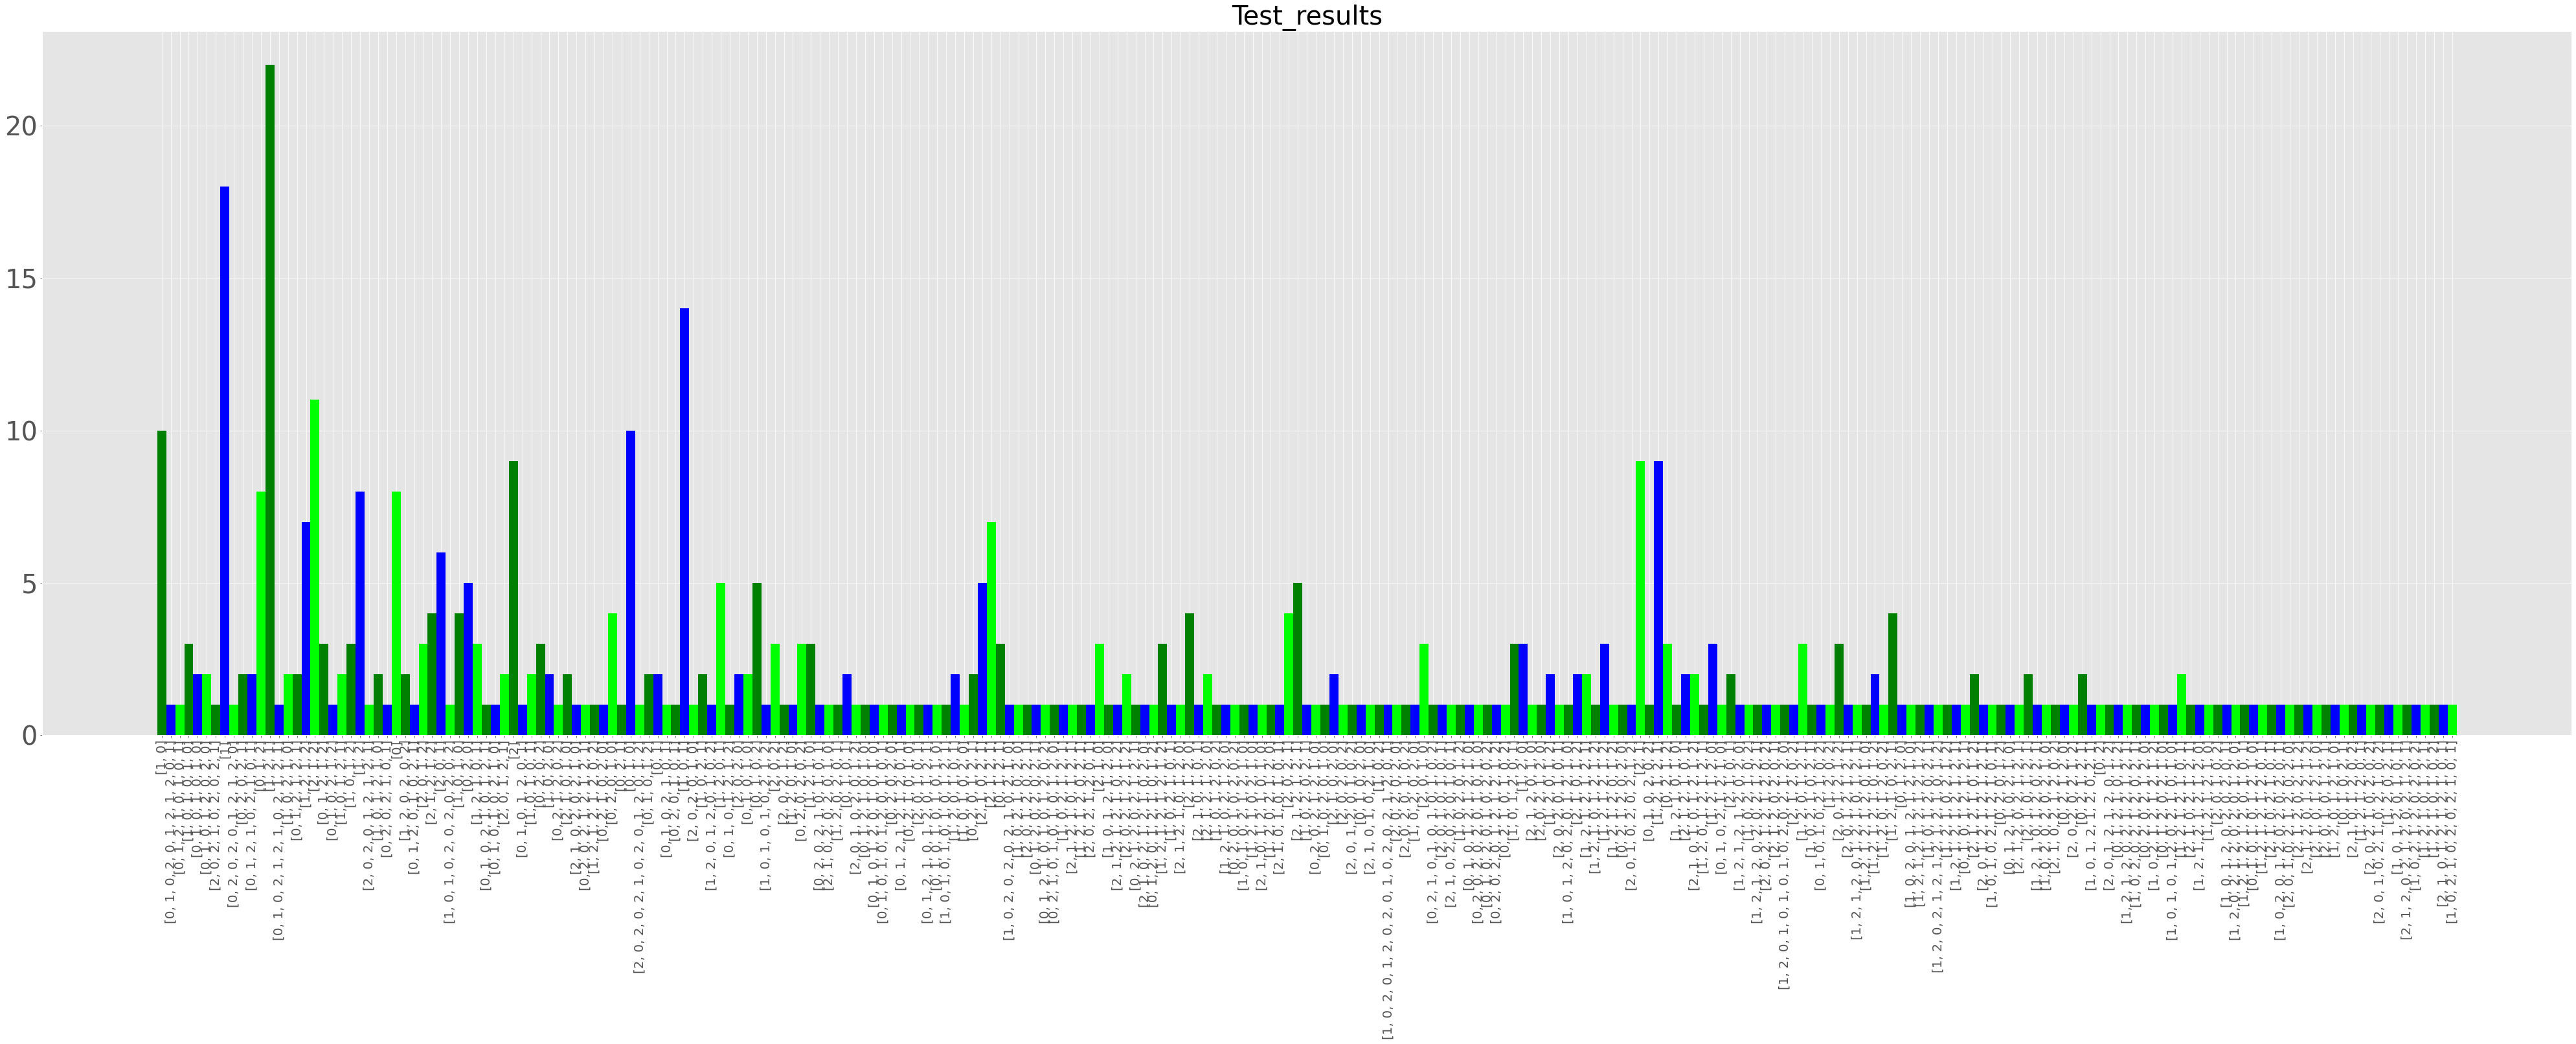

In [ ]:
p = test_patterns.copy()

p_keys = list(Counter(p).keys())
p_values = list(Counter(p).values())
plot_histogram_patterns(p_keys, p_values, 'Test_results')

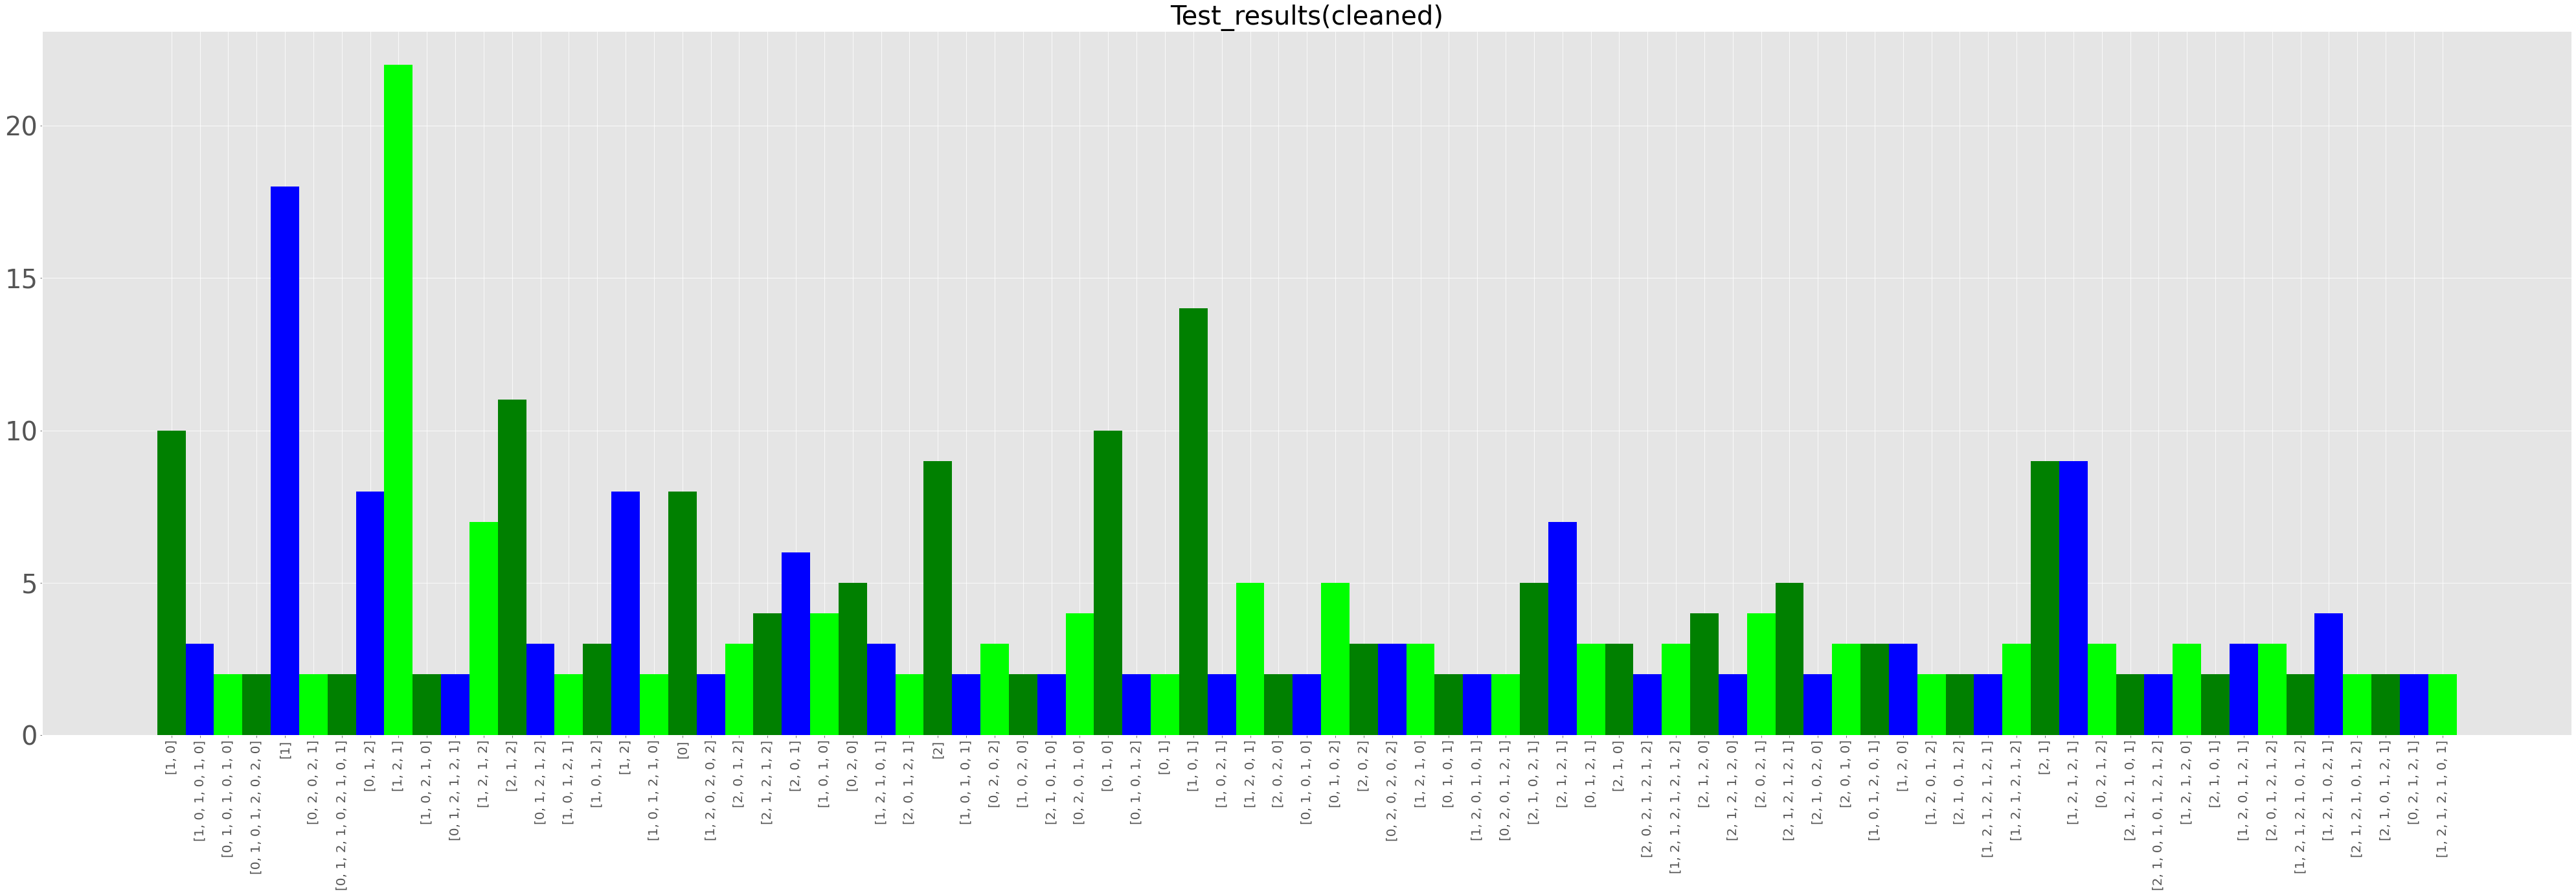

In [ ]:
#delete patter_series with one value
one_repeated_el=[]
for i in range(len(p_keys)):
  if p_values[i] == 1:
    p.remove(p_keys[i])

p_keys = list(Counter(p).keys())
p_values = list(Counter(p).values())
plot_histogram_patterns(p_keys, p_values, 'Test_results(cleaned)')

##7

The number of possible classes is equal to the sum of states with lengths from one to nine.
In each case, only the first element can have three states and the rest of the elements can have only two states.
Other the conversation ids that have a duplicate member eventually become one of these states (after applying the process described in Section 6).
example:

[0],[1],[2]    ->  possible classes in this case is 3

[0,1], [0,2], [1,0], [1,2],[2,0], [2,1]   -> possible classes in this case is3 * 2^1


.....


.............................................................................................-> 3 * 2^((mean_length-1)=8)

In [ ]:
def get_possible_classes(patterns,loader):

  n_classes = len(list(Counter(patterns).keys()))


  conversation_ids=[]
  len_conversation_ids=[]
  for batch, sample in enumerate(loader):
    conversation_ids.extend(sample['conversation_id'])

  dict = {i:None for i in conversation_ids}
  conversation_ids = list(dict.keys())

  len_conversation_ids=[]
  for item in conversation_ids:
    len_conversation_ids.append(len(ast.literal_eval(item)))

  mean_len = int(np.mean(len_conversation_ids))

  n_possible_classes = 0
  for i in range(mean_len):
    n_possible_classes+= 3 * (2**(i))

  return mean_len, n_possible_classes, n_classes

### train_results

In [ ]:
mean_len, n_possible_classes, n_classes = get_possible_classes(train_patterns, train_dataloader)
print('The average length of conversations:{}\nnumber of possible is {}, number of real classes is {} and ratio is{}'.format(mean_len, n_possible_classes, n_classes, n_classes/n_possible_classes ))

The average length of conversations:9
number of possible is 1533, number of real classes is 681 and ratio is0.44422700587084146


### validation_results

In [ ]:
mean_len, n_possible_classes, n_classes = get_possible_classes(dev_patterns, dev_dataloader)
print('The average length of conversations:{}\nnumber of possible is {}, number of real classes is {} and ratio is {}'.format(mean_len, n_possible_classes, n_classes, n_classes/n_possible_classes ))

The average length of conversations:10
number of possible is 3069, number of real classes is 250 and ratio is 0.08145975887911372


### test_results

In [ ]:
mean_len, n_possible_classes, n_classes = get_possible_classes(test_patterns, test_dataloader)
print('The average length of conversations:{}\nnumber of possible is {}, number of real classes is {} and ratio is {}'.format(mean_len, n_possible_classes, n_classes, n_classes/n_possible_classes ))

The average length of conversations:9
number of possible is 1533, number of real classes is 255 and ratio is 0.16634050880626222
